## 1 Robot1
- Q1.1 Implement a KNN classifier.
- Q1.2 Report precision, recall, f1 score and accuracy.
- Q1.3 Compare your result with in-built(scikit-learn) KNN function to check correctness of your algorithm.(10 points)
- Q2.1 Use different distance measures as applicable. 
- Q2.2 Plot graph to report accuracy with change in value of K. Also suggest possible reason for better performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.datatools import train_test_split
from utils.metrics import accuracy

## Helper Functions

### Functions to get distance measures

In [2]:
from math import sqrt

def euclidean_distance(x, y, dims=None):
    if dims is not None:
        x, y = x[:dims], y[:dims]
    
    return np.sqrt(np.sum((x - y) ** 2)) 


def manhattan_distance(x, y, dims=None):
    if dims is not None:
        x, y = x[:dims], y[:dims]
    
    return np.sum(np.absolute(x-y))


def chebyshev_distance(x, y, dims=None):
    if dims is not None:
        x, y = x[:dims], y[:dims]
    
    return np.max(np.absolute(x-y))


def cosine_distance(x, y, dims=None):
    if dims is not None:
        x, y = x[:dims], y[:dims]
    
    n = np.sum(x * y)
    a = np.sqrt(np.sum(x**2))
    b = np.sqrt(np.sum(y**2))
    
    return 1 - (n / (a*b))

In [3]:
print("Sample point1:", [1,9,0], "Sample point2:",[4,3,7])
print("euclidean_distance:", euclidean_distance(np.array([1,9,0]),np.array([4,3,7])))
print("manhattan_distance:", manhattan_distance(np.array([1,9,0]),np.array([4,3,7])))
print("chebyshev_distance:", chebyshev_distance(np.array([1,9,0]),np.array([4,3,7])))
print("cosine_distance:", cosine_distance(np.array([1,9,0]),np.array([4,3,7])))

Sample point1: [1, 9, 0] Sample point2: [4, 3, 7]
euclidean_distance: 9.695359714832659
manhattan_distance: 16
chebyshev_distance: 7
cosine_distance: 0.6020404713786001


In [4]:
def get_k_nearest_neighbours(training_df, test_point, k, distance_measure_algo):
    """Returns k nearest neighbours of test_point, among training_points"""
    dimensions = len(test_point) - 1  # -1 to not consider class label when calculating distance
    dists = np.apply_along_axis(distance_measure_algo, 1, training_df, test_point, dimensions)
    distances = np.column_stack((dists, training_df))

    distances = distances[distances[:, 0].argsort()]
    k_neighbours = distances[:k, 1:]
    return k_neighbours


def best_class(neighbours):
    """Returns most prominent class label among the neighbours."""
    class_labels = neighbours[:,-1]
    unique_labels, counts = np.unique(class_labels, return_counts=True)
    index = counts.argmax()
    return unique_labels[index]

In [5]:
def classify_example(example, training_df, k, distance_measure_algo):
    """Predicts the class label for the example data."""
    neighbours = get_k_nearest_neighbours(training_df, example.values, k, distance_measure_algo)
    return best_class(neighbours)

In [6]:
def predict(test_df, train_df, k, distance_measure_algo):
    """Adds a classification column to the test dataframe. 
    This classification column contains the predictions made by the columns."""
    predictions = test_df.apply(classify_example, axis=1, args=(train_df, k,distance_measure_algo))
    predictions.name="classification"
    return predictions

In [7]:
def confusion_matrix(df):
    """Creates confusion matrix with true labels along rows and predicted labels along columns.
    Assumes df contains a column "label"=>True labels"""
    rows = cols= np.unique(df["label"].values)
    
    matrix = np.ndarray(shape=(len(rows), len(cols)), dtype=float)
    for ri, row in enumerate(rows):
        for ci, col in enumerate(cols):
            matrix[ri][ci] = len(df[(df.label == row) & (df.classification == col)])
    
    return matrix, rows, cols


In [8]:
def plot_confusion_heatmap(df, xlabel='Predicted labels', ylabel='True labels',
                           xticks_rotation=45, yticks_rotation=0, fontsize=14):
    """Plots the heatmap for confusion matrix of a given dataframe"""
    matrix, class_names, _ = confusion_matrix(df)

    df_cm = pd.DataFrame(
        matrix, index=class_names, columns=class_names,
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt='g')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=xticks_rotation, ha='right',
                                 fontsize=fontsize)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=yticks_rotation, ha='right',
                                 fontsize=fontsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


### Functions to measure model performance 

In [9]:
def true_positive(cf, true_class_index):
    return cf[true_class_index][true_class_index]


def false_positive(cf, true_class_index):
    column_sum = np.sum(cf, axis=0)[true_class_index]     
    return column_sum - true_positive(cf, true_class_index)


def false_negative(cf, true_class_index):
    row_sum = np.sum(cf, axis=1)[true_class_index]     
    return row_sum - true_positive(cf, true_class_index)


def true_negative(cf, true_class_index):
    matrix_sum = np.sum(cf)
    row_sum = np.sum(cf, axis=1)[true_class_index]     
    column_sum = np.sum(cf, axis=0)[true_class_index]
    # using inclusion exclusion principle
    return matrix_sum - row_sum - column_sum + true_positive(cf, true_class_index)


def precision(df, true_class):
    # precision = TP / (TP+FP)
    cf, class_labels, __ = confusion_matrix(df)
    true_class_index = np.where(class_labels==true_class)[0][0]
    TP = true_positive(cf, true_class_index)
    FP = false_positive(cf, true_class_index)
    return  TP / (TP + FP)


def recall(df, true_class):
    # recall = TP / (TP + FN)
    cf, class_labels, __ = confusion_matrix(df)
    true_class_index = np.where(class_labels == true_class)[0][0]
    TP = true_positive(cf, true_class_index)
    FN = false_negative(cf, true_class_index)
    return  TP / (TP + FN)
    

def f1_score(df, true_class, p=None, r=None):
    if p is None:
        p = precision(df, true_class)
    if r is None:
        r = recall(df, true_class)

    if p + r == 0:
        return 0

    return 2 * (p * r) / (p + r)

## 1.1 Robot1

### Read csv file

In [10]:
def read_csv(file_path):
    df = pd.read_csv(file_path, header=None, sep=' ').dropna(axis=1, how='all')
    # add column names header
    df.columns = ["class", "a1", "a2", "a3", "a4", "a5", "a6", "Id"]

    # we do not need Id column
    df.drop(['Id'], axis=1, inplace=True)

    # make class label the last column 
    cols = df.columns.tolist()
    cols.remove("class")
    df = df[cols +["class"]]

    target = "label"
    # rename the column whose value is to be predicted to "label"
    df = df.rename(columns={"class": target}) 

    df.head(3)
    
    return df
    
df = read_csv("../data/robot/Robot1")

# Q1.1 Implement a KNN classifier.

In [11]:
number_of_neighbours = 5

train_df, validate_df = train_test_split(df, test_size = 0.2, random_state=1)

predictions = predict(validate_df, train_df, k=number_of_neighbours, distance_measure_algo=euclidean_distance)

actual = validate_df["label"]

combined_df = pd.concat([actual, predictions],axis=1)



 # Q1.2 Report precision, recall, f1_score and accuracy

precision 0.8
recall 0.8571428571428571
f1_score 0.8275862068965518
accuracy 0.8


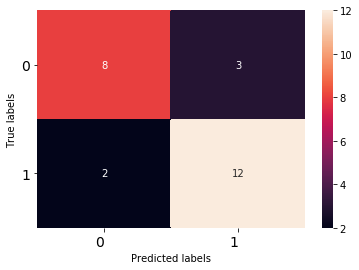

In [12]:
print("precision", precision(combined_df, 1))

print("recall", recall(combined_df, 1))

print("f1_score", f1_score(combined_df, 1))

print("accuracy", accuracy(combined_df))

plot_confusion_heatmap(combined_df, xticks_rotation=0)

# Q1.3 Compare your result with in-built(scikit-learn) KNN function to check correctness of your algorithm

# Comparison with sklearn

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = validate_df.drop(["label"], axis=1), validate_df["label"]

model = KNeighborsClassifier(n_neighbors=number_of_neighbours)

# Train the model using the training set
model.fit(X_train, y_train)

# Predict Output
y_pred = model.predict(X_test)

# Report accuracy
accuracy_score(y_test, y_pred)

0.8

# Q2.1 Use different distance measures as applicable.

## Using euclidean distance

In [14]:
predictions = predict(validate_df, train_df, k=number_of_neighbours, distance_measure_algo=euclidean_distance)
actual = validate_df["label"]
combined_df = pd.concat([actual, predictions],axis=1)

print("accuracy", accuracy(combined_df))


accuracy 0.8


## Using Manhattan distance

In [15]:
predictions = predict(validate_df, train_df, k=number_of_neighbours, distance_measure_algo=manhattan_distance)
actual = validate_df["label"]
combined_df = pd.concat([actual, predictions],axis=1)

print("accuracy", accuracy(combined_df))


accuracy 0.84


## Using Chebyshev distance

In [16]:
predictions = predict(validate_df, train_df, k=number_of_neighbours, distance_measure_algo=chebyshev_distance)
actual = validate_df["label"]
combined_df = pd.concat([actual, predictions],axis=1)

print("accuracy", accuracy(combined_df))


accuracy 0.8


## Using Cosine distance

In [17]:
predictions = predict(validate_df, train_df, k=number_of_neighbours, distance_measure_algo=cosine_distance)
actual = validate_df["label"]
combined_df = pd.concat([actual, predictions],axis=1)

print("accuracy", accuracy(combined_df))


accuracy 0.84


### Plot for sklearn model

1 0.76;	2 0.72;	3 0.72;	4 0.72;	5 0.8;	6 0.72;	7 0.72;	8 0.72;	9 0.72;	


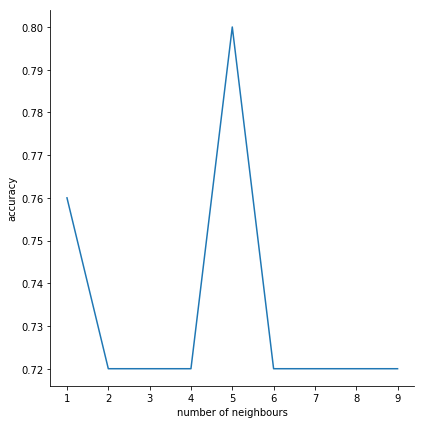

In [18]:
from math import sqrt, floor
accuracies = []
n_samples = floor(sqrt(len(train_df)))
X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = validate_df.drop(["label"], axis=1), validate_df["label"]

for k in range(1, n_samples+1):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accu = accuracy_score(y_test, y_pred)
    print(k, accu, end=";\t")
    accuracies.append((k, accu))

print()
plotdf = pd.DataFrame(accuracies, index=range(n_samples), columns=["number of neighbours", "accuracy"])
sns.relplot( y="accuracy", x="number of neighbours", kind="line", data=plotdf, height=6)


# Q2.2 Plot graph to report accuracy with change in value of K. Also suggest possible reason for better performance.

### Plot for our KNN implementation

1 0.76;	2 0.72;	3 0.68;	4 0.72;	5 0.8;	6 0.72;	7 0.68;	8 0.72;	9 0.76;	


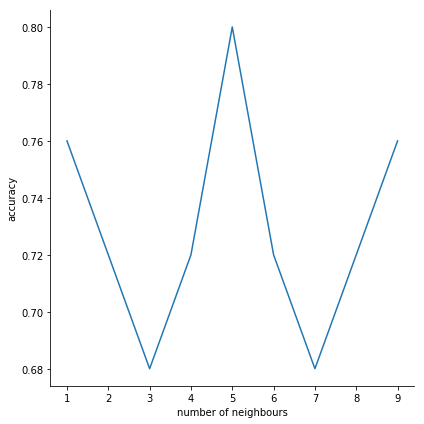

In [19]:
from math import sqrt, floor
accuracies = []
n_samples = floor(sqrt(len(train_df)))

for k in range(1, n_samples + 1):
    predictions = predict(validate_df, train_df, k, euclidean_distance)
    actual = validate_df["label"]
    combined_df = pd.concat([actual, predictions], axis=1)
    accu = accuracy(combined_df)
    print(k, accu, end=";\t")
    accuracies.append((k, accu))
    
print()
plotdf = pd.DataFrame(accuracies, index=range(n_samples), columns=["number of neighbours", "accuracy"])
sns.relplot( y="accuracy", x="number of neighbours", kind="line", data=plotdf, height=6)


#### Reason for improvement
Increasing the value of k leads to smoothening of the classified class reducing the false classifications until a threshold value of k.

# Load test data from supplied command line path

In [20]:
import sys
if len(sys.argv) != 2:
    print("Please supply test file path")
    exit(1)

test_file_path = sys.argv[1]
print("Loading test data from:", test_file_path)


Please supply test file path
Loading test data from: -f


precision 0.8983050847457628
recall 0.8548387096774194
f1_score 0.8760330578512397
accuracy 0.8790322580645161


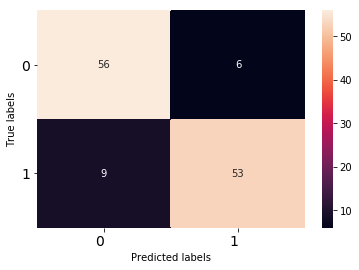

In [21]:
# STOPSHIP
if test_file_path == "-f":
    test_file_path = "../data/robot/Robot1"
    
test_df = read_csv(test_file_path)

predictions = predict(test_df, train_df, 5, cosine_distance)
actual = test_df["label"]
combined_df = pd.concat([actual, predictions], axis=1)


print("precision", precision(combined_df, 1))

print("recall", recall(combined_df, 1))

print("f1_score", f1_score(combined_df, 1))

print("accuracy", accuracy(combined_df))

plot_confusion_heatmap(combined_df, xticks_rotation=0)